In [1]:
import numpy as np
import matplotlib.pylab as plt
def graph(name):
    # Determinar dimensiones de la malla
    data = np.loadtxt(f"../data/{name}", skiprows=3)
    X = data[:,2]
    Y = data[:,3]
    U = data[:,4]#.reshape(5,5)
    V = data[:,5]#.reshape(5,5)
    P = data[:,6]#.reshape(5,5)
    XY = np.meshgrid(X,Y)


    nx = len(np.unique(X))
    ny = len(np.unique(Y))

    # Redimensionar arrays
    X_grid = X.reshape(ny, nx)
    Y_grid = Y.reshape(ny, nx)
    U_grid = U.reshape(ny, nx)
    V_grid = V.reshape(ny, nx)
    P_grid = P.reshape(ny, nx)

    # Crear figura combinada
    plt.figure(figsize=(8, 6))

    # Mapa de contorno de presión
    contour = plt.contourf(X_grid, Y_grid, P_grid, cmap='viridis')
    plt.colorbar(contour, label='Presión P')

    # Superponer campo vectorial de velocidades
    plt.quiver(X_grid, Y_grid, U_grid*5, V_grid*5, color='black', scale=10)

    # Etiquetas y formato
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Presión y Campo de Velocidades')
    plt.axis('equal')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(f"../images/{name}.png")
    plt.show()

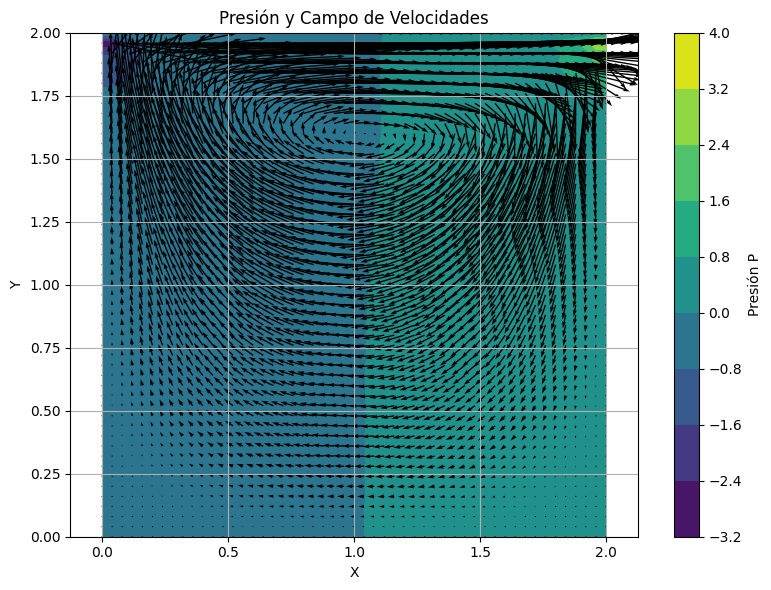

In [2]:
graph("campos_510.txt")

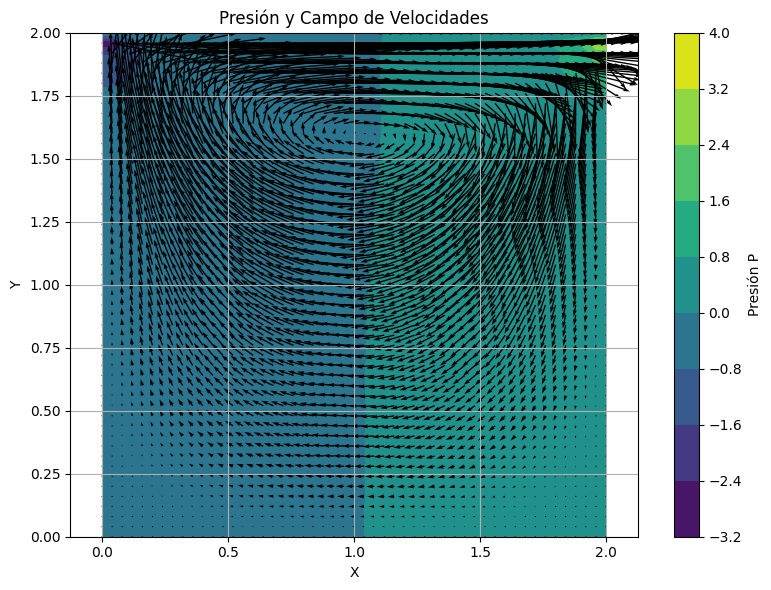

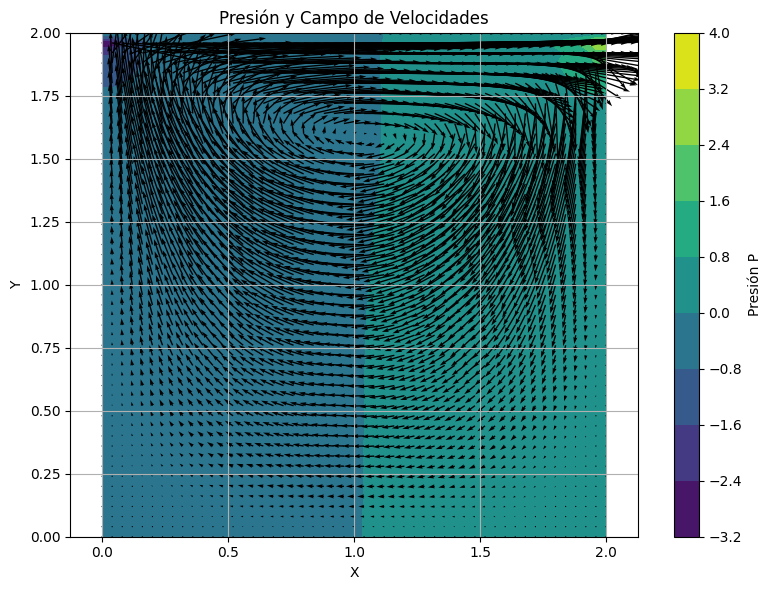

FileNotFoundError: ../data/campos_530.txt not found.

In [3]:
file_names = [f"campos_{i:03}.txt" for i in range(510, 1500, 10)]
for f in file_names:
    graph(f)

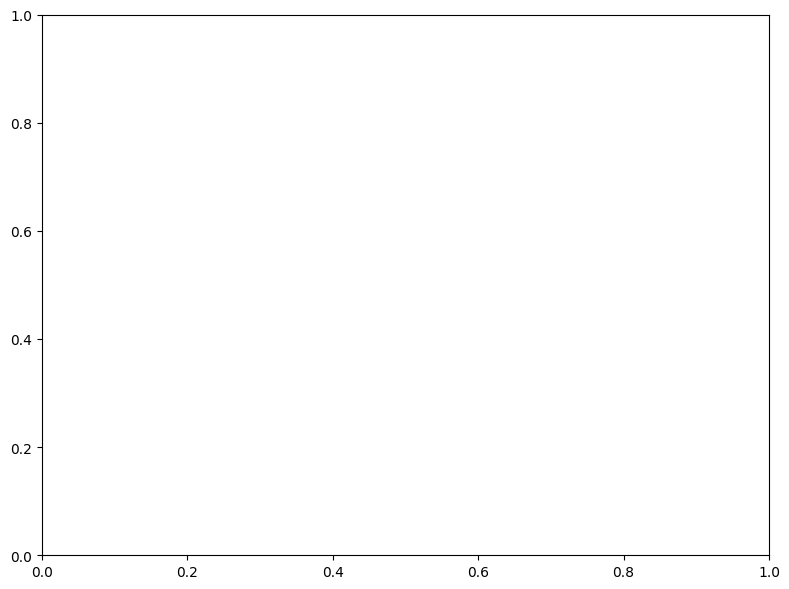

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# Ruta base de los archivos
data_dir = "../data"

# Generar la lista de nombres en orden
file_names = [f"campos_{i:03}.txt" for i in range(510, 2000, 10)]
file_paths = [os.path.join(data_dir, name) for name in file_names]

# Cargar la primera para extraer la grilla
data = np.loadtxt(file_paths[0], skiprows=3)
X = data[:, 2]
Y = data[:, 3]
nx = len(np.unique(X))
ny = len(np.unique(Y))
X_grid = X.reshape(ny, nx)
Y_grid = Y.reshape(ny, nx)

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))
contourf = None
quiver = None

# Inicialización de la animación
def init():
    global contourf, quiver
    ax.clear()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Presión y Campo de Velocidades')
    ax.set_aspect('equal')
    ax.grid(True)
    return []

# Función de actualización para cada frame
def update(frame_index):
    global contourf, quiver
    ax.clear()

    # Cargar archivo correspondiente
    data = np.loadtxt(file_paths[frame_index], skiprows=3)
    X = data[:, 2]
    Y = data[:, 3]
    U = data[:, 4]
    V = data[:, 5]
    P = data[:, 6]

    X_grid = X.reshape(ny, nx)
    Y_grid = Y.reshape(ny, nx)
    U_grid = U.reshape(ny, nx)
    V_grid = V.reshape(ny, nx)
    P_grid = P.reshape(ny, nx)

    # Dibujar contorno
    contourf = ax.contourf(X_grid, Y_grid, P_grid, cmap='viridis')
#    quiver = ax.quiver(X_grid, Y_grid, U_grid, V_grid, color='white', scale=20)
    quiver = ax.quiver(X_grid, Y_grid, U_grid, V_grid, color='white', scale=0.1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Presión y Campo de Velocidades (frame {frame_index})')
    ax.set_aspect('equal')
    ax.grid(True)

    return contourf.collections + [quiver]

# Crear animación
ani = animation.FuncAnimation(
    fig, update, frames=len(file_paths), init_func=init, blit=False, interval=200
)

# Mostrar animación
plt.tight_layout()
plt.show()


In [ ]:

# Guardar como video opcional:
ani.save("animacion_campos.mp4", writer='ffmpeg', fps=5)


/var/folders/6s/h5hh29jn1dqd4r627s043vy40000gn/T/ipykernel_61123/605712146.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contourf.collections + [quiver]


In [ ]:
import re
import numpy as np
import plotly.graph_objects as go

def _load_grid_from_txt(path):
    """
    Lee el archivo y devuelve X,Y,U,V,P en mallas 2D ordenadas.
    """
    data = np.loadtxt(path, skiprows=3)
    X = data[:, 2]
    Y = data[:, 3]
    U = data[:, 4]
    V = data[:, 5]
    P = data[:, 6]

    xs = np.unique(X)
    ys = np.unique(Y)
    nx, ny = len(xs), len(ys)

    # Orden estable por (Y,X) para poder reshape sin sorpresas
    order = np.lexsort((X, Y))
    Xg = X[order].reshape(ny, nx)
    Yg = Y[order].reshape(ny, nx)
    Ug = U[order].reshape(ny, nx)
    Vg = V[order].reshape(ny, nx)
    Pg = P[order].reshape(ny, nx)
    return Xg, Yg, Ug, Vg, Pg

def _extract_number(name):
    m = re.findall(r'(\d+)', name)
    if not m: 
        return None
    m.sort(key=lambda s: (len(s), s))
    return float(m[-1])

def graph3d_single(name="campos_510.txt", base_path="../data", z0=None,
                   cone_subsample=1, cone_size=0.8, point_size=2.5):
    """
    Dibuja: (1) flechas de velocidad, (2) puntos del grid, (3) plano coloreado por presión.
    - name: nombre del archivo (p.ej. 'campos_510.txt')
    - base_path: carpeta donde está el archivo
    - z0: altura del plano (por defecto intenta extraer número del nombre; si no, 0.0)
    - cone_subsample: muestreo entero de las flechas (1=todas, 2=cada 2, ...)
    - cone_size: tamaño absoluto de conos (ajusta según magnitud de U,V)
    - point_size: tamaño de los marcadores del grid
    """
    path = f"{base_path}/{name}"
    Xg, Yg, Ug, Vg, Pg = _load_grid_from_txt(path)

    if z0 is None:
        znum = _extract_number(name)
        z0 = 0.0 if znum is None else znum

    # --- (1) Campo de velocidad (conos) ---
    if cone_subsample > 1:
        Xc = Xg[::cone_subsample, ::cone_subsample]
        Yc = Yg[::cone_subsample, ::cone_subsample]
        Uc = Ug[::cone_subsample, ::cone_subsample]
        Vc = Vg[::cone_subsample, ::cone_subsample]
    else:
        Xc, Yc, Uc, Vc = Xg, Yg, Ug, Vg

    Zc = np.full_like(Xc, z0, dtype=float)
    Wc = np.zeros_like(Uc)

    cone = go.Cone(
        x=Xc.flatten(), y=Yc.flatten(), z=Zc.flatten(),
        u=Uc.flatten(), v=Vc.flatten(), w=Wc.flatten(),
        sizemode="absolute", sizeref=cone_size,
        anchor="tail",
        showscale=False,
        name="Velocidad"
    )

    # --- (2) Puntos del grid ---
    Zp = np.full_like(Xg, z0, dtype=float)
    pts = go.Scatter3d(
        x=Xg.flatten(), y=Yg.flatten(), z=Zp.flatten(),
        mode="markers",
        marker=dict(size=point_size),
        name="Puntos"
    )

    # --- (3) Plano de presión ---
    # Para que sea un “plano” literal, fijamos Z constante y coloreamos con P
    Zplane = np.full_like(Xg, z0, dtype=float)
    Pmin, Pmax = float(np.min(Pg)), float(np.max(Pg))
    surf = go.Surface(
        x=Xg, y=Yg, z=Zplane,
        surfacecolor=Pg,
        colorscale="Viridis",
        cmin=Pmin, cmax=Pmax,
        showscale=True,
        colorbar=dict(title="Presión P"),
        opacity=0.85,
        name="Presión (plano)"
    )

    # Orden de trazas: primero velocidad, luego puntos, luego plano
    fig = go.Figure(data=[cone, pts, surf])

    fig.update_layout(
        title=f"Archivo: {name} — Velocidad (conos), Puntos y Plano de Presión en z={z0}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z (tiempo/índice)",
            aspectmode="data"
        ),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    fig.show()
    return fig


In [ ]:
# igual que tu graph("campos_510.txt"), pero en 3D con Plotly:
graph3d_single("data1/campos_510.txt", base_path="../data1", z0=510, cone_subsample=2, cone_size=0.6, point_size=3)


FileNotFoundError: ../data/data1/campos_510.txt not found.